# AdaGrad算法
:label:`sec_adagrad`

我们从有关特征学习中并不常见的问题入手。

## 稀疏特征和学习率

假设我们正在训练一个语言模型。
为了获得良好的准确性，我们大多希望在训练的过程中降低学习率，速度通常为$\mathcal{O}(t^{-\frac{1}{2}})$或更低。
现在讨论关于稀疏特征（即只在偶尔出现的特征）的模型训练，这对自然语言来说很常见。
例如，我们看到“预先条件”这个词比“学习”这个词的可能性要小得多。
但是，它在计算广告学和个性化协同过滤等其他领域也很常见。

只有在这些不常见的特征出现时，与其相关的参数才会得到有意义的更新。
鉴于学习率下降，我们可能最终会面临这样的情况：常见特征的参数相当迅速地收敛到最佳值，而对于不常见的特征，我们仍缺乏足够的观测以确定其最佳值。
换句话说，学习率要么对于常见特征而言降低太慢，要么对于不常见特征而言降低太快。

解决此问题的一个方法是记录我们看到特定特征的次数，然后将其用作调整学习率。
即我们可以使用大小为$\eta_i = \frac{\eta_0}{\sqrt{s(i, t) + c}}$的学习率，而不是$\eta = \frac{\eta_0}{\sqrt{t + c}}$。
在这里$s(i, t)$计下了我们截至$t$时观察到功能$i$的次数。
这其实很容易实施且不产生额外损耗。

AdaGrad算法 :cite:`Duchi.Hazan.Singer.2011`通过将粗略的计数器$s(i, t)$替换为先前观察所得梯度的平方之和来解决这个问题。
它使用$s(i, t+1) = s(i, t) + \left(\partial_i f(\mathbf{x})\right)^2$来调整学习率。
这有两个好处：首先，我们不再需要决定梯度何时算足够大。
其次，它会随梯度的大小自动变化。通常对应于较大梯度的坐标会显著缩小，而其他梯度较小的坐标则会得到更平滑的处理。
在实际应用中，它促成了计算广告学及其相关问题中非常有效的优化程序。
但是，它遮盖了AdaGrad固有的一些额外优势，这些优势在预处理环境中很容易被理解。

## 预处理

凸优化问题有助于分析算法的特点。
毕竟对大多数非凸问题来说，获得有意义的理论保证很难，但是直觉和洞察往往会延续。
让我们来看看最小化$f(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{c}^\top \mathbf{x} + b$这一问题。

正如在 :numref:`sec_momentum`中那样，我们可以根据其特征分解$\mathbf{Q} = \mathbf{U}^\top \boldsymbol{\Lambda} \mathbf{U}$重写这个问题，来得到一个简化得多的问题，使每个坐标都可以单独解出：

$$f(\mathbf{x}) = \bar{f}(\bar{\mathbf{x}}) = \frac{1}{2} \bar{\mathbf{x}}^\top \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}}^\top \bar{\mathbf{x}} + b.$$

在这里我们使用了$\mathbf{x} = \mathbf{U} \mathbf{x}$，且因此$\mathbf{c} = \mathbf{U} \mathbf{c}$。
修改后优化器为$\bar{\mathbf{x}} = -\boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}}$且最小值为$-\frac{1}{2} \bar{\mathbf{c}}^\top \boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}} + b$。
这样更容易计算，因为$\boldsymbol{\Lambda}$是一个包含$\mathbf{Q}$特征值的对角矩阵。

如果稍微扰动$\mathbf{c}$，我们会期望在$f$的最小化器中只产生微小的变化。
遗憾的是，情况并非如此。
虽然$\mathbf{c}$的微小变化导致了$\bar{\mathbf{c}}$同样的微小变化，但$f$的（以及$\bar{f}$的）最小化器并非如此。
每当特征值$\boldsymbol{\Lambda}_i$很大时，我们只会看到$\bar{x}_i$和$\bar{f}$的最小值发声微小变化。
相反，对小的$\boldsymbol{\Lambda}_i$来说，$\bar{x}_i$的变化可能是剧烈的。
最大和最小的特征值之比称为优化问题的*条件数*（condition number）。

$$\kappa = \frac{\boldsymbol{\Lambda}_1}{\boldsymbol{\Lambda}_d}.$$

如果条件编号$\kappa$很大，准确解决优化问题就会很难。
我们需要确保在获取大量动态的特征值范围时足够谨慎：难道我们不能简单地通过扭曲空间来“修复”这个问题，从而使所有特征值都是$1$？
理论上这很容易：我们只需要$\mathbf{Q}$的特征值和特征向量即可将问题从$\mathbf{x}$整理到$\mathbf{z} := \boldsymbol{\Lambda}^{\frac{1}{2}} \mathbf{U} \mathbf{x}$中的一个。
在新的坐标系中，$\mathbf{x}^\top \mathbf{Q} \mathbf{x}$可以被简化为$\|\mathbf{z}\|^2$。
可惜，这是一个相当不切实际的想法。
一般而言，计算特征值和特征向量要比解决实际问题“贵”得多。

虽然准确计算特征值可能会很昂贵，但即便只是大致猜测并计算它们，也可能已经比不做任何事情好得多。
特别是，我们可以使用$\mathbf{Q}$的对角线条目并相应地重新缩放它。
这比计算特征值开销小的多。

$$\tilde{\mathbf{Q}} = \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q}) \mathbf{Q} \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q}).$$

在这种情况下，我们得到了$\tilde{\mathbf{Q}}_{ij} = \mathbf{Q}_{ij} / \sqrt{\mathbf{Q}_{ii} \mathbf{Q}_{jj}}$，特别注意对于所有$i$，$\tilde{\mathbf{Q}}_{ii} = 1$。
在大多数情况下，这大大简化了条件数。
例如我们之前讨论的案例，它将完全消除眼下的问题，因为问题是轴对齐的。

遗憾的是，我们还面临另一个问题：在深度学习中，我们通常情况甚至无法计算目标函数的二阶导数：对于$\mathbf{x} \in \mathbb{R}^d$，即使只在小批量上，二阶导数可能也需要$\mathcal{O}(d^2)$空间来计算，导致几乎不可行。
AdaGrad算法巧妙的思路是，使用一个代理来表示黑塞矩阵（Hessian）的对角线，既相对易于计算又高效。

为了了解它是如何生效的，让我们来看看$\bar{f}(\bar{\mathbf{x}})$。
我们有

$$\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}}) = \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}} = \boldsymbol{\Lambda} \left(\bar{\mathbf{x}} - \bar{\mathbf{x}}_0\right),$$

其中$\bar{\mathbf{x}}_0$是$\bar{f}$的优化器。
因此，梯度的大小取决于$\boldsymbol{\Lambda}$和与最佳值的差值。
如果$\bar{\mathbf{x}} - \bar{\mathbf{x}}_0$没有改变，那这就是我们所求的。
毕竟在这种情况下，梯度$\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}})$的大小就足够了。
由于AdaGrad算法是一种随机梯度下降算法，所以即使是在最佳值中，我们也会看到具有非零方差的梯度。
因此，我们可以放心地使用梯度的方差作为黑塞矩阵比例的廉价替代。
详尽的分析（要花几页解释）超出了本节的范围，请读者参考 :cite:`Duchi.Hazan.Singer.2011`。

## 算法

让我们接着上面正式开始讨论。
我们使用变量$\mathbf{s}_t$来累加过去的梯度方差，如下所示：

$$\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}$$

在这里，操作是按照坐标顺序应用。
也就是说，$\mathbf{v}^2$有条目$v_i^2$。
同样，$\frac{1}{\sqrt{v}}$有条目$\frac{1}{\sqrt{v_i}}$，
并且$\mathbf{u} \cdot \mathbf{v}$有条目$u_i v_i$。
与之前一样，$\eta$是学习率，$\epsilon$是一个为维持数值稳定性而添加的常数，用来确保我们不会除以$0$。
最后，我们初始化$\mathbf{s}_0 = \mathbf{0}$。

就像在动量法中我们需要跟踪一个辅助变量一样，在AdaGrad算法中，我们允许每个坐标有单独的学习率。
与SGD算法相比，这并没有明显增加AdaGrad的计算代价，因为主要计算用在$l(y_t, f(\mathbf{x}_t, \mathbf{w}))$及其导数。

请注意，在$\mathbf{s}_t$中累加平方梯度意味着$\mathbf{s}_t$基本上以线性速率增长（由于梯度从最初开始衰减，实际上比线性慢一些）。
这产生了一个学习率$\mathcal{O}(t^{-\frac{1}{2}})$，但是在单个坐标的层面上进行了调整。
对于凸问题，这完全足够了。
然而，在深度学习中，我们可能希望更慢地降低学习率。
这引出了许多AdaGrad算法的变体，我们将在后续章节中讨论它们。
眼下让我们先看看它在二次凸问题中的表现如何。
我们仍然以同一函数为例：

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

我们将使用与之前相同的学习率来实现AdaGrad算法，即$\eta = 0.4$。
可以看到，自变量的迭代轨迹较平滑。
但由于$\boldsymbol{s}_t$的累加效果使学习率不断衰减，自变量在迭代后期的移动幅度较小。


In [1]:
%matplotlib inline
import math
import torch
# from d2l import torch as d2l

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_trace_2d(f, results):
    """显示优化过程中2D变量的轨迹"""
    # 设置图形大小
    plt.figure(figsize=(6, 4))
    
    # 绘制优化轨迹
    x_coords, y_coords = zip(*results)
    plt.plot(x_coords, y_coords, '-o', color='#ff7f0e')
    
    # 创建网格点用于绘制等高线
    x1_range = torch.arange(-5.5, 1.0, 0.1)
    x2_range = torch.arange(-3.0, 1.0, 0.1)
    x1, x2 = torch.meshgrid(x1_range, x2_range, indexing='ij')
    
    # 计算目标函数值并绘制等高线
    z = f(x1, x2)
    plt.contour(x1.numpy(), x2.numpy(), z.numpy(), colors='#1f77b4')
    
    # 添加坐标轴标签
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    # 添加网格
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 显示图形
    plt.tight_layout()
    plt.show()

def train_2d(trainer, steps=20, f_grad=None):  #@save
    """用定制的训练机优化2D目标函数"""
    # s1和s2是稍后将使用的内部状态变量
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

epoch 20, x1: -2.382563, x2: -0.158591


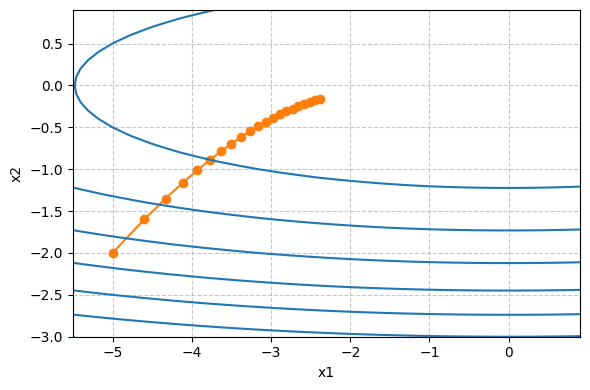

In [3]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
show_trace_2d(f_2d, train_2d(adagrad_2d))

我们将学习率提高到$2$，可以看到更好的表现。
这已经表明，即使在无噪声的情况下，学习率的降低可能相当剧烈，我们需要确保参数能够适当地收敛。


epoch 20, x1: -0.002295, x2: -0.000000


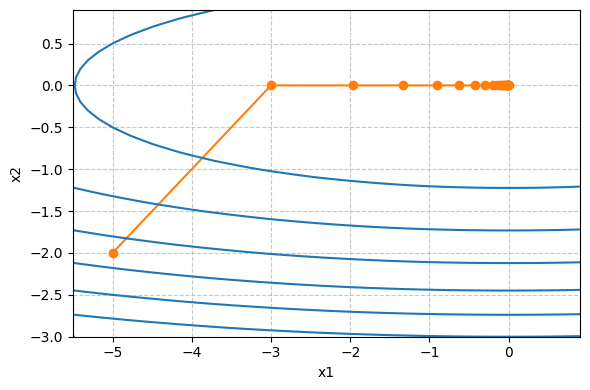

In [4]:
eta = 2
show_trace_2d(f_2d, train_2d(adagrad_2d))

## 从零开始实现

同动量法一样，AdaGrad算法需要对每个自变量维护同它一样形状的状态变量。


In [5]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

与 :numref:`sec_minibatch_sgd`一节中的实验相比，这里使用更大的学习率来训练模型。


In [6]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

def download_file(url, filename):
    """下载文件"""
    import urllib.request
    import os
    
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filename)
    else:
        print(f"{filename} already exists.")
    return filename

def load_array(data_arrays, batch_size, is_train=True):
    """构建PyTorch数据迭代器"""
    dataset = TensorDataset(*data_arrays)
    return DataLoader(dataset, batch_size, shuffle=is_train)

# 数据集信息
DATA_HUB = {}
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['airfoil'] = (DATA_URL + 'airfoil_self_noise.dat',
                       '76e5be1548fd8222e5074cf0faae75edff8cf93f')

def get_data_ch11(batch_size=10, n=1500):
    """
    获取空气动力学数据集
    
    参数:
    - batch_size: 批量大小
    - n: 使用的样本数量
    
    返回:
    - data_iter: 数据迭代器
    - feature_dim: 特征维度
    """
    # 下载数据
    url, sha1_hash = DATA_HUB['airfoil']
    filename = 'airfoil_self_noise.dat'
    download_file(url, filename)
    
    # 加载数据
    data = np.genfromtxt(filename, dtype=np.float32, delimiter='\t')
    
    # 数据标准化：移除均值并缩放方差为1
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    
    # 取前n个样本，特征为前几列，标签为最后一列
    features = torch.from_numpy(data[:n, :-1])
    labels = torch.from_numpy(data[:n, -1])
    
    # 创建数据加载器
    data_iter = load_array((features, labels), batch_size, is_train=True)
    
    # 返回数据迭代器和特征维度
    return data_iter, data.shape[1]-1

In [7]:
from IPython import display
import torch

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        
        # 替换 d2l.use_svg_display()
        import matplotlib.pyplot as plt
        plt.rcParams['figure.figsize'] = figsize
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 替换 d2l.set_axes，使用 lambda 函数直接配置参数
        self.config_axes = lambda: self._set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def _set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置坐标轴标签、范围和比例"""
        import matplotlib.pyplot as plt
        # 设置坐标轴标签
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        # 设置坐标轴范围
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        # 设置坐标轴比例
        if xscale:
            ax.set_xscale(xscale)
        if yscale:
            ax.set_yscale(yscale)
        # 设置图例
        if legend:
            ax.legend(legend)
        # 添加网格
        ax.grid(True)

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

import time
import numpy as np
import torch

class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # 初始化模型
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: linreg(X, w, b), squared_loss
    # 训练模型
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

loss: 0.243, 0.005 sec/epoch


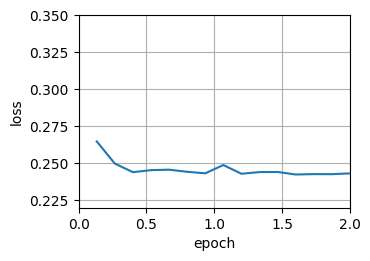

In [8]:
data_iter, feature_dim = get_data_ch11(batch_size=10)
train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

## 简洁实现

我们可直接使用深度学习框架中提供的AdaGrad算法来训练模型。


In [10]:
from torch import nn
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # 初始化模型
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # MSELoss计算平方误差时不带系数1/2
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

loss: 0.242, 0.006 sec/epoch


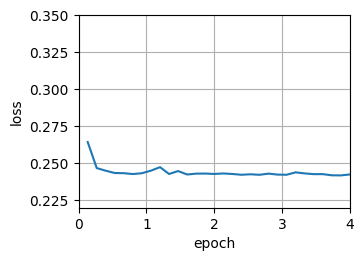

In [11]:
trainer = torch.optim.Adagrad
train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

## 小结

* AdaGrad算法会在单个坐标层面动态降低学习率。
* AdaGrad算法利用梯度的大小作为调整进度速率的手段：用较小的学习率来补偿带有较大梯度的坐标。
* 在深度学习问题中，由于内存和计算限制，计算准确的二阶导数通常是不可行的。梯度可以作为一个有效的代理。
* 如果优化问题的结构相当不均匀，AdaGrad算法可以帮助缓解扭曲。
* AdaGrad算法对于稀疏特征特别有效，在此情况下由于不常出现的问题，学习率需要更慢地降低。
* 在深度学习问题上，AdaGrad算法有时在降低学习率方面可能过于剧烈。我们将在 :numref:`sec_adam`一节讨论缓解这种情况的策略。

## 练习

1. 证明对于正交矩阵$\mathbf{U}$和向量$\mathbf{c}$，以下等式成立：$\|\mathbf{c} - \mathbf{\delta}\|_2 = \|\mathbf{U} \mathbf{c} - \mathbf{U} \mathbf{\delta}\|_2$。为什么这意味着在变量的正交变化之后，扰动的程度不会改变？
1. 尝试对函数$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2$、以及它旋转45度后的函数即$f(\mathbf{x}) = 0.1 (x_1 + x_2)^2 + 2 (x_1 - x_2)^2$使用AdaGrad算法。它的表现会不同吗？
1. 证明[格什戈林圆盘定理](https://en.wikipedia.org/wiki/Gershgorin_circle_theorem)，其中提到，矩阵$\mathbf{M}$的特征值$\lambda_i$在至少一个$j$的选项中满足$|\lambda_i - \mathbf{M}_{jj}| \leq \sum_{k \neq j} |\mathbf{M}_{jk}|$的要求。
1. 关于对角线预处理矩阵$\mathrm{diag}^{-\frac{1}{2}}(\mathbf{M}) \mathbf{M} \mathrm{diag}^{-\frac{1}{2}}(\mathbf{M})$的特征值，格什戈林的定理告诉了我们什么？
1. 尝试对适当的深度网络使用AdaGrad算法，例如，:numref:`sec_lenet`中应用于Fashion-MNIST的深度网络。
1. 要如何修改AdaGrad算法，才能使其在学习率方面的衰减不那么激进？


[Discussions](https://discuss.d2l.ai/t/4319)
